In [1]:
%load_ext autoreload
%autoreload 2
import sys
import collections
import numpy as np
# sys.path.append("/private/home/alexandrerame/domainbedv2/")
# sys.path.append("/private/home/alexandrerame/slurmconfig/notebook/data")

sys.path.append("/home/rame/domainbedv2/")

from domainbed.codeplot import plot
plot.plt.style.use('default')
sys.path.append("/data/rame/logs_experiments_notebook/")

In [2]:
plot.plt.rcParams["figure.figsize"] = (6, 6)
# plot.plt.rcParams['text.usetex'] = True
# plot.plt.rcParams['font.family'] = 'serif'
plot.plt.rcParams['font.serif'] = 'Times Roman'
# plot.FORMAT_X = 1
# plot.FORMAT_Y = 3
plot.dict_key_to_label.update(
    {
        "ROUGE_L": "Rouge score",
        "Bleu_1": "Bleu score",
        "Bleu_4": "Bleu4 score",
        "METEOR": "Meteor score"
    }
)


In [3]:
from captioning import fts_bleu4, fts_bleu, fts_rouge, fts_meteor, fts_bleurouge, fts_bleumeteor, fts_bleubleu4, fts_rougebleu4
from captioning import e2e_bleu, e2e_bleu4, e2e_rouge, e2e_bleurouge, e2e_bleu4rouge, e2e_meteor, e2e_bleubleu4, e2e_bleumeteor

# bleu to bleu4

In [4]:
do_save= True

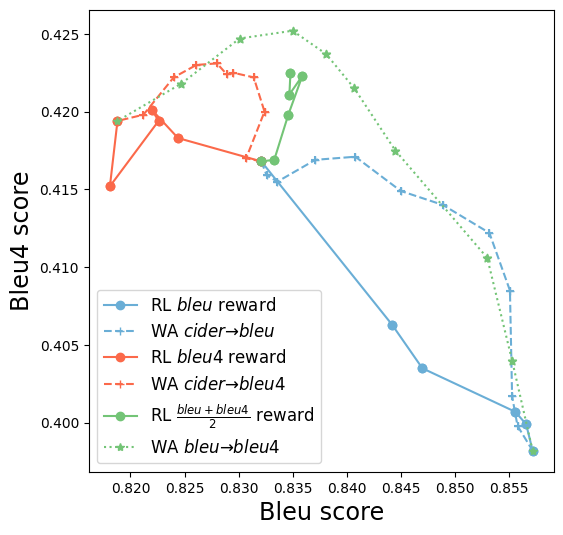

In [5]:
fig_dr = plot.plot_key(
    [
        e2e_bleu.l_step, e2e_bleu.l_wa, e2e_bleu4.l_step, e2e_bleu4.l_wa, e2e_bleubleu4.l_step,
        e2e_bleubleu4.l_wa_bleu4bleu
    ],
    key_x="Bleu_1",
    key_y="Bleu_4",
    labels=[
        r"RL $bleu$ reward", r"WA $cider \to bleu$", r"RL $bleu4$ reward", r"WA $cider \to bleu4$",
        r"RL $\frac{bleu+bleu4}{2}$ reward", r"WA $bleu \to bleu4$"
    ],
    loc="lower left",
    # keycolor="lambda",
    colormaps=['Blues', 'Blues', 'Reds', 'Reds', "Greens", 'Greens'],
    linestyles=['solid', 'dashed', 'solid', 'dashed', "solid", 'dotted'],
    connect_points=True
)
plot.save_fig(fig=fig_dr, name="captioning/pareto_captioning_bleutobleu4.pdf", do_save=do_save)

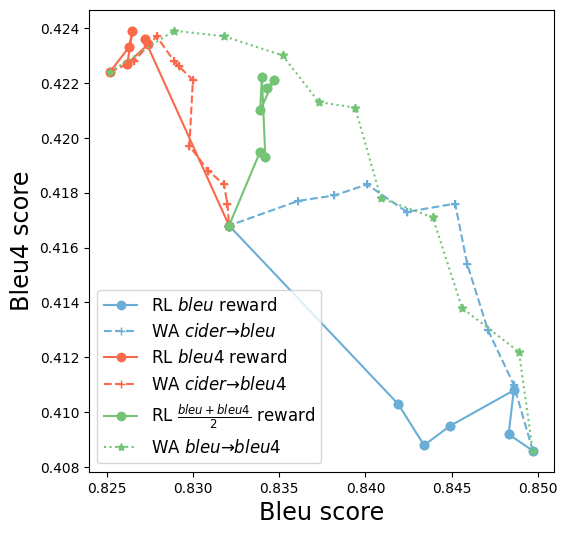

In [6]:
fig_dr = plot.plot_key(
    [
        fts_bleu.l_step, fts_bleu.l_wa_step5, fts_bleu4.l_step, fts_bleu4.l_wa,
        fts_bleubleu4.l_step, fts_bleubleu4.l_wa
    ],
    key_x="Bleu_1",
    key_y="Bleu_4",
    labels=[
        r"RL $bleu$ reward", r"WA $cider \to bleu$", r"RL $bleu4$ reward", r"WA $cider \to bleu4$",
        r"RL $\frac{bleu+bleu4}{2}$ reward", r"WA $bleu \to bleu4$"
    ],
    loc="lower left",
    # keycolor="lambda",
    colormaps=['Blues', 'Blues', 'Reds', 'Reds', "Greens", 'Greens'],
    linestyles=['solid', 'dashed', 'solid', 'dashed', "solid", 'dotted'],
    connect_points=True
)
plot.save_fig(fig=fig_dr, name="captioning/pareto_captioning_e2e_bleutobleu4.pdf", do_save=do_save)

# bleu to meteor

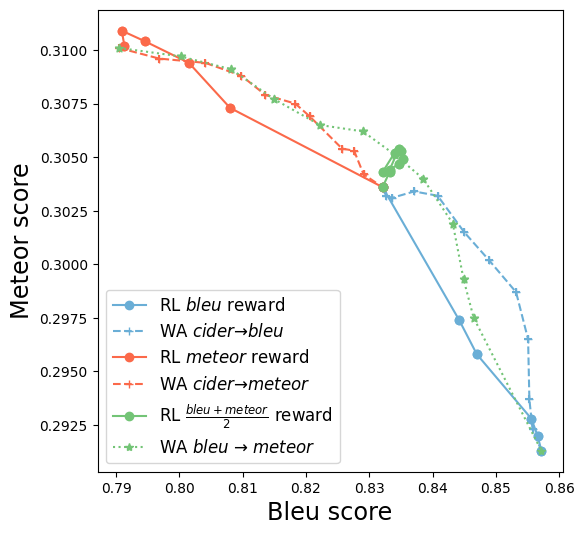

In [7]:
fig_dr = plot.plot_key(
    [
        e2e_bleu.l_step, e2e_bleu.l_wa, e2e_meteor.l_step, e2e_meteor.l_wa, e2e_bleumeteor.l_step,
        e2e_bleumeteor.l_wa_meteorbleu
    ],
    key_x="Bleu_1",
    key_y="METEOR",
    labels=[
        r"RL $bleu$ reward", r"WA $cider \to bleu$", r"RL $meteor$ reward",
        r"WA $cider \to meteor$", r"RL $\frac{bleu+meteor}{2}$ reward", r"WA $bleu$ $\to$ $meteor$"
    ],
    loc="lower left",
    # keycolor="lambda",
    colormaps=['Blues', 'Blues', 'Reds', 'Reds', "Greens", 'Greens'],
    linestyles=['solid', 'dashed', 'solid', 'dashed', "solid", 'dotted'],
    connect_points=True
)
plot.save_fig(fig=fig_dr, name="captioning/pareto_captioning_e2e_bleutometeor.pdf", do_save=do_save)

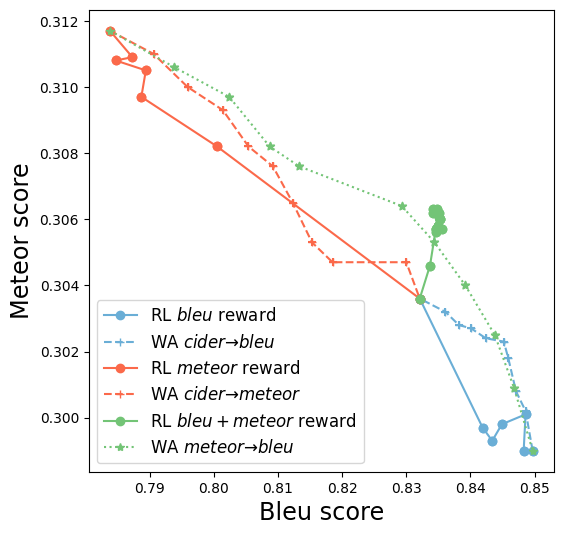

In [8]:
fig_dr = plot.plot_key(
    [
        fts_bleu.l_step,
        fts_bleu.l_wa_step5,
        fts_meteor.l_step,
        fts_meteor.l_wa,
        fts_bleumeteor.l_step,
        fts_bleumeteor.l_wa,
    ],
    # list_indexes = [0,1,3,5,6],
    # list_indexes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    key_x="Bleu_1",
    key_y="METEOR",
    labels=[
        r"RL $bleu$ reward",
        r"WA $cider \to bleu$",
        r"RL $meteor$ reward",
        r"WA $cider \to meteor$",
        r"RL $bleu+meteor$ reward",
        r"WA $meteor \to bleu$",
    ],
    loc="lower left",
    # keycolor="lambda",
    colormaps=[
        "Blues",
        "Blues",
        "Reds",
        "Reds",
        "Greens",
        "Greens",
    ],
    linestyles=[
        ls if ls not in [] else None
        for ls in ["solid", "dashed", "solid", "dashed", "solid", "dotted"]
    ],
    connect_points=True,
    order=2,
)
plot.save_fig(fig=fig_dr, name="captioning/pareto_captioning_bleutometeor.pdf", do_save=do_save)

# Bleu to ROUGE

Text(0.8378, 0.6088, '$\\frac{bleu+rouge}{2}$ ft')

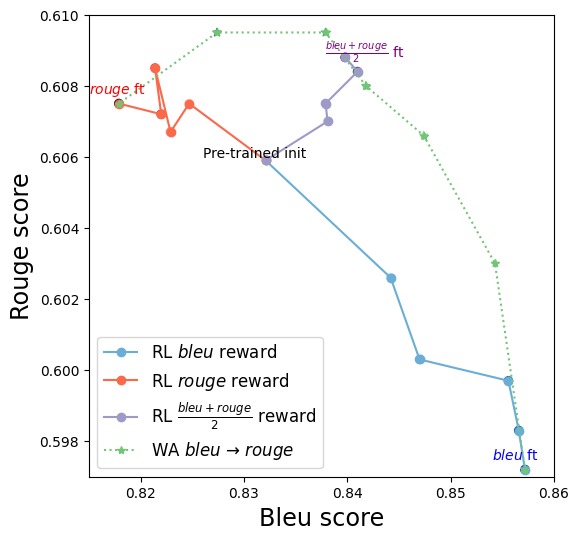

In [9]:
fig_dr = plot.plot_key(
    [
        e2e_bleu.l_step, e2e_rouge.l_step, e2e_bleurouge.l_step_rougebleu,
        e2e_bleurouge.l_wa_rougebleu
    ],
    key_x="Bleu_1",
    key_y="ROUGE_L",
    labels=[
        r"RL: $bleu$ reward", r"RL: $rouge$ reward", r"RL: $\frac{bleu+rouge}{2}$ reward",
        r"WA: $bleu$ $\to$ $rouge$"
    ],
    loc="lower left",
    keycolor="lambda",
    colormaps=['Blues', 'Reds', "Purples", 'Greens'],
    linestyles=['solid', 'solid', "solid", 'dotted'],
    _dict_key_to_limit={
        "Bleu_1": [0.815, 0.86],
        "ROUGE_L": [0.597, 0.610]
    },
    connect_points=True
)
plot.plt.annotate("Pre-trained init", xy=(0.826, 0.606))
plot.plt.annotate(r"$rouge$ ft", xy=(0.815, 0.6078), color="red")
plot.plt.annotate(r"$bleu$ ft", xy=(0.854, 0.5975), color="blue")
plot.plt.annotate(r"$\frac{bleu+rouge}{2}$ ft", xy=(0.8378, 0.6088), color="purple")

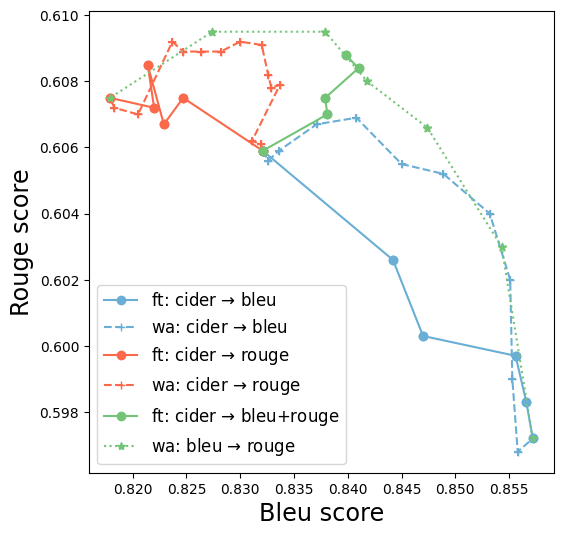

In [10]:
fig_dr = plot.plot_key(
    [
        e2e_bleu.l_step, e2e_bleu.l_wa, e2e_rouge.l_step, e2e_rouge.l_wa,
        e2e_bleurouge.l_step_rougebleu, e2e_bleurouge.l_wa_rougebleu
    ],
    key_x="Bleu_1",
    key_y="ROUGE_L",
    labels=[
        r"ft: cider $\to$ bleu", r"wa: cider $\to$ bleu", r"ft: cider $\to$ rouge",
        r"wa: cider $\to$ rouge", r"ft: cider $\to$ bleu+rouge", r"wa: bleu $\to$ rouge"
    ],
    loc="lower left",
    # keycolor="lambda",
    colormaps=['Blues', 'Blues', 'Reds', 'Reds', 'Greens', 'Greens'],
    linestyles=['solid', 'dashed', 'solid', 'dashed', "solid", 'dotted'],
    connect_points=True
)

plot.save_fig(fig=fig_dr, name="captioning/pareto_captioning_e2e_bleutorouge.pdf", do_save=do_save)

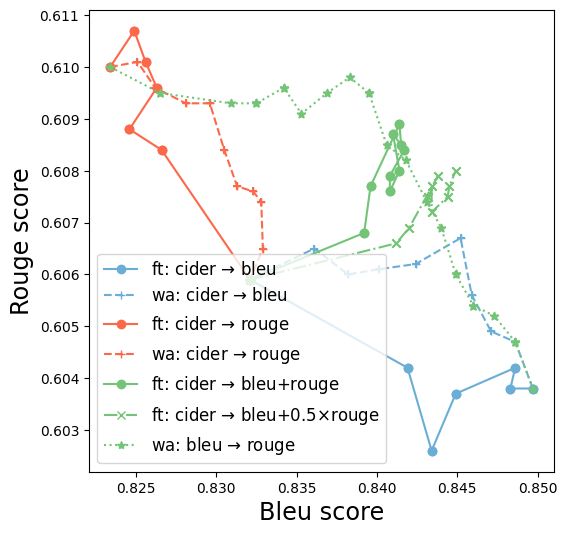

In [11]:
fig_dr = plot.plot_key(
    [
        fts_bleu.l_step, fts_bleu.l_wa_step5, fts_rouge.l_step, fts_rouge.l_wa_step5,
        fts_bleurouge.l_step, fts_bleurouge.l_step_15, fts_bleurouge.l_wa_epoch5
    ],
    key_x="Bleu_1",
    key_y="ROUGE_L",
    labels=[
        r"ft: cider $\to$ bleu", r"wa: cider $\to$ bleu", r"ft: cider $\to$ rouge",
        r"wa: cider $\to$ rouge", r"ft: cider $\to$ bleu+rouge",
        r"ft: cider $\to$ bleu+0.5$\times$rouge", r"wa: bleu $\to$ rouge"
    ],
    loc="lower left",
    # keycolor="lambda",
    colormaps=['Blues', 'Blues', 'Reds', 'Reds', 'Greens', 'Greens', 'Greens'],
    linestyles=[
        'solid',
        'dashed',
        'solid',
        'dashed',
        "solid",
        "dashdot",
        'dotted',
    ],
    connect_points=True
)
plot.save_fig(fig=fig_dr, name="captioning/pareto_captioning_bleutorouge.pdf", do_save=do_save)

# bleu4 to rouge

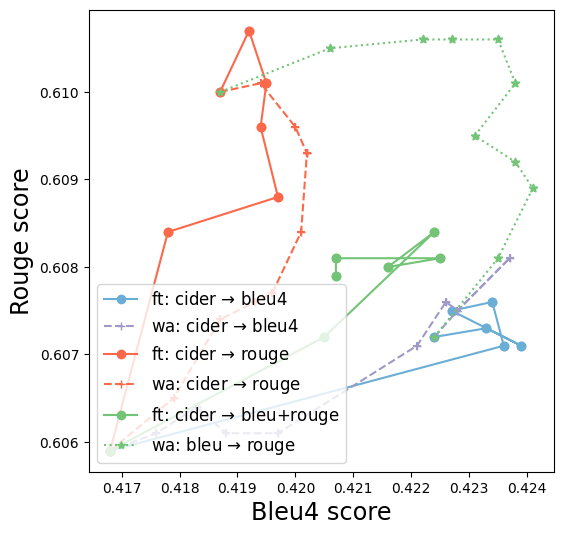

In [12]:
fig_dr = plot.plot_key(
    [
        fts_bleu4.l_step,
        fts_bleu4.l_wa,
        fts_rouge.l_step,
        fts_rouge.l_wa_step5,
        fts_rougebleu4.l_step,
        fts_rougebleu4.l_wa,
    ],
    key_x="Bleu_4",
    key_y="ROUGE_L",
    labels=[
        r"ft: cider $\to$ bleu4", r"wa: cider $\to$ bleu4", r"ft: cider $\to$ rouge",
        r"wa: cider $\to$ rouge", r"ft: cider $\to$ bleu4+rouge",
        r"wa: bleu $\to$ rouge"
    ],
    loc="lower left",
    # keycolor="lambda",
    colormaps=['Blues', 'Purples', 'Reds', 'Reds', 'Greens', 'Greens'],
    linestyles=[
        'solid',
        'dashed',
        'solid',
        'dashed',
        "solid",
        'dotted',
    ],
    connect_points=True
)
plot.save_fig(fig=fig_dr, name="captioning/pareto_captioning_bleu4torouge.pdf", do_save=do_save)

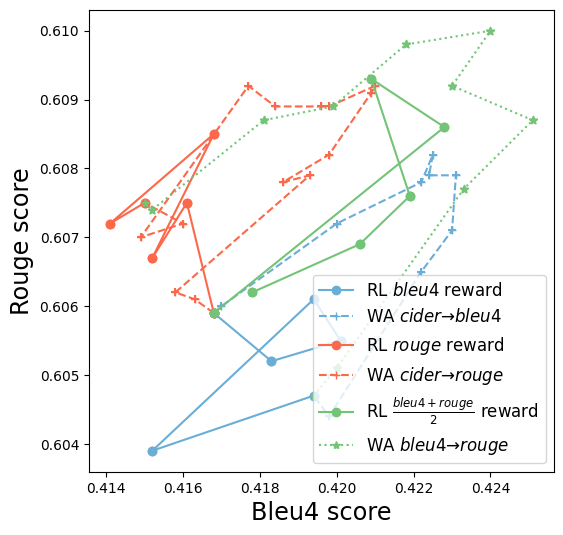

In [14]:
plot.plt.rcParams["figure.figsize"] = (6, 6)
fig_dr = plot.plot_key(
    [
        e2e_bleu4.l_step, e2e_bleu4.l_wa,
        e2e_rouge.l_step, e2e_rouge.l_wa,
        e2e_bleu4rouge.l_step, e2e_bleu4rouge.l_wa
    ],
    key_x="Bleu_4",
    key_y="ROUGE_L",
    labels=[
        r"RL $bleu4$ reward",
        r"WA $cider \to bleu4$",
        r"RL $rouge$ reward",
        r"WA $cider \to rouge$",
        r"RL $\frac{bleu4+rouge}{2}$ reward",
        r"WA $bleu4 \to rouge$"
    ],
    loc="lower right",
    # keycolor="lambda",
    colormaps=['Blues', 'Blues',  'Reds', 'Reds', "Greens", 'Greens'],
    linestyles=['solid', 'dashed', 'solid', 'dashed', "solid", 'dotted'],
    connect_points=True
)
plot.save_fig(fig=fig_dr, name="captioning/pareto_captioning_e2e_bleu4torouge.pdf", do_save=do_save)

In [15]:
plot.plt.rcParams["figure.figsize"] = (7, 7)
plot.SIZE_AXIS = "small"
plot.SIZE = "small"
fig_dr = plot.plot_key(
    [
        fts_rouge.l_step,
        fts_rouge.l_wa_step5,
        fts_bleu.l_step,
        fts_bleu.l_wa_step5,
        fts_bleu.l_wa,
        fts_bleu4.l_step,
        fts_meteor.l_step,
        fts_meteor.l_steplr,
        fts_bleurouge.l_step,
        fts_bleurouge.l_step_15,
        fts_bleumeteor.l_step,
        fts_bleurouge.l_wa_epoch5,
        fts_bleurouge.l_wa_epoch10,
        fts_bleumeteor.l_wa,
    ],
    # list_indexes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    key_x="Bleu_1",
    key_y="METEOR",
    labels=[
        r"RL $rouge$ reward",
        r"WA $init \to rouge$",
        r"RL $bleu$ reward",
        r"WA $init \to bleu$ epoch 5",
        r"WA $init \to bleu$ epoch 10",
        r"RL $bleu4$ reward",
        r"RL $meteor$ reward",
        r"RL $meteor$ reward small lr",
        r"RL $bleu+rouge$ reward",
        r"RL $bleu+0.5 \times rouge$ reward",
        r"RL $bleu+meteor$ reward",
        r"WA $rouge \to bleu$ epoch 5",
        r"WA $rouge \to bleu$ epoch 10",
        r"WA $meteor \to bleu$ epoch 5",
    ],
    loc="lower left",
    keycolor="lambda",
    colormaps=[
        "Reds",
        "Reds",
        "Blues",
        "Blues",
        "Blues",
        "Dark_Blues",
        "Greys",
        "Dark_Greys",
        "Purples",
        "Purples",
        "Blues_Greys",
        'Greens',
        "Greens",
        "Blues_Greys",
    ],
    linestyles=[
        ls if ls not in [] else None for ls in [
            "solid", "dashed", "solid", "dashed", "dashdot", "solid", "solid", "solid", "dotted",
            "dotted", "dotted", 'dashed', "dashdot", "dashed"
        ]
    ],
    connect_points=True,
    order=2,
    _dict_key_to_limit={
        "Bleu_1": [0.78, 0.86],
        "ROUGE_L": [0.60, 0.612],
        "METEOR": [0.29, 0.32]
    },
)

AttributeError: module 'captioning.fts_bleu' has no attribute 'l_wa'